In [1]:
#Notebook for experimenting with pytables
import numpy as np
import tables
import SimpleITK as sitk
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def images_to_hdf5(image_list,label_list,
                   img_reader, label_reader,
                   post_processor,
                   output_fn):
    """
    takes a list of images, post processes them and stores result in extendable
    hdf5 table
    
    inputs:
        - image_list, (list of strings), list of image filenames, readable by reader
        - reader, (function), reader compatible with the file type in image_list
        - post_processor, (function), post processes output of reader, must return list of np arrays with same shape
        - output_fn, (string), ouput filename, must be hdf5 file
    """
    EXPECTED_ROWS = 10000
    
    img = img_reader(image_list[0])
    lab = label_reader(label_list[0])
    
    img_nps, lab_nps = post_processor(img,lab)
    
    #infer shape and dtype from data
    shape = img_nps[0].shape
    dtype = img_nps[0].dtype
    lab_shape = lab_nps[0].shape
    lab_dtype = lab_nps[0].dtype
    print shape
    #create hdf5 file
    hdf5_file = tables.open_file(output_fn,'w')
    filters = tables.Filters(complevel=5, complib='blosc')
    
    data_storage = hdf5_file.create_earray(hdf5_file.root,'X',
                                      tables.Atom.from_dtype(dtype),
                                      shape=[0]+list(shape[1:]),
                                         filters=filters,
                                         expectedrows=EXPECTED_ROWS)
    
    label_storage = hdf5_file.create_earray(hdf5_file.root,'Y',
                                      tables.Atom.from_dtype(lab_dtype),
                                      shape=[0]+list(lab_shape[1:]),
                                         filters=filters,
                                         expectedrows=EXPECTED_ROWS)
    for i in range(len(img_nps)):
        data_storage.append(img_nps[i])
        label_storage.append(lab_nps[i])
        
    for i in range(len(image_list)):
        print 'image {}'.format(i)
        img = img_reader(image_list[i])
        lab = label_reader(label_list[i])
        
        img_nps, lab_nps = post_processor(img,lab)
        
        for j in range(len(img_nps)):
            data_storage.append(img_nps[j])
            label_storage.append(lab_nps[j])
            
    hdf5_file.close()

In [3]:
image_list = open('/home/marsdenlab/projects/tcl_code/python/data/192full/images.txt').readlines()
image_list = [i.replace('\n','') for i in image_list]

truth_list = open('/home/marsdenlab/projects/tcl_code/python/data/192full/truths.txt').readlines()
truth_list = [i.replace('\n','') for i in truth_list]
image_list[0]

'/home/marsdenlab/datasets/vascular_data/OSMSC0001/OSMSC0001-cm.mha'

In [4]:
STRIDE = 16
DIM = 48
def mha_reader(s):
    mha = sitk.ReadImage(s)
    img_np = sitk.GetArrayFromImage(mha)
    return img_np.copy()

def processor(x,y):
    img_list = []
    lab_list = []
    
    W,H,D = x.shape
    for i in range(DIM/2,W-DIM/2,STRIDE):
        for j in range(DIM/2,H-DIM/2,STRIDE):
            for k in range(DIM/2,D-DIM/2,STRIDE):
                img = x[i-DIM/2:i+DIM/2,j-DIM/2:j+DIM/2,k-DIM/2:k+DIM/2]
                lab = y[i-DIM/2:i+DIM/2,j-DIM/2:j+DIM/2,k-DIM/2:k+DIM/2]

                if np.mean(img) < 50:
                    continue
                else:
                    img = img.reshape((1,DIM,DIM,DIM))
                    lab = lab.reshape((1,DIM,DIM,DIM))
                    img_list.append(img.copy())
                    lab_list.append(lab.copy())
    return img_list,lab_list

In [ ]:
output_hdf5 = 'test.hdf5'
images_to_hdf5(image_list[:10],truth_list[:10],
                   mha_reader, mha_reader,
                   processor,
                   output_hdf5)

(1, 48, 48, 48)
image 0
image 1
image 2
image 3
image 4
image 5
image 6
image 7
image 8


In [6]:
f = tables.open_file(output_hdf5, 'r')

In [15]:
X = f.root.X[100:110]
Y = f.root.Y[100:110]
print X.shape
print Y.shape
print np.sum(np.abs(X-Y))

(10, 48, 48, 48)
(10, 48, 48, 48)
0


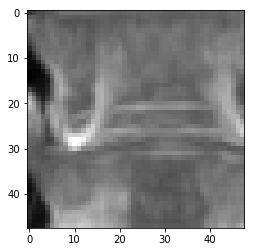

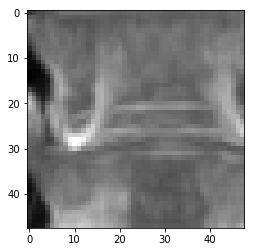

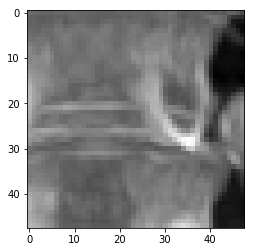

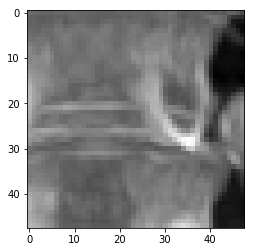

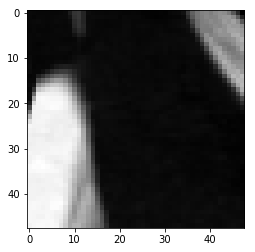

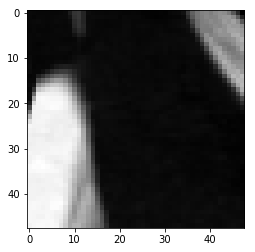

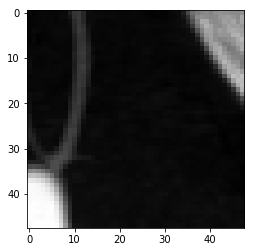

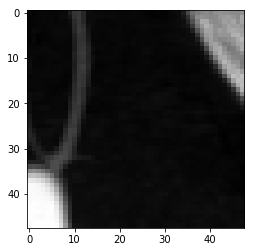

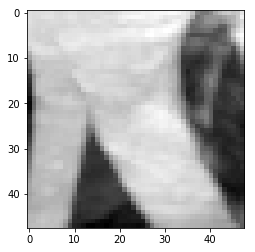

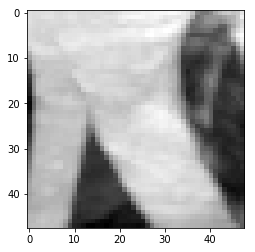

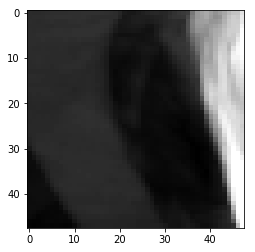

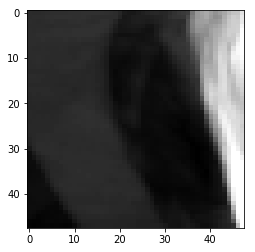

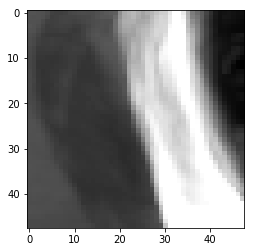

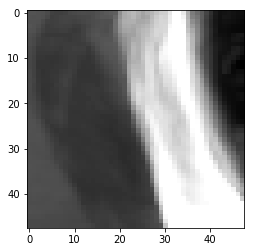

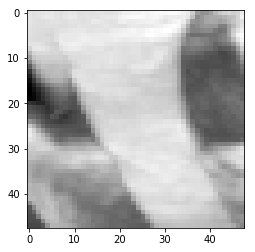

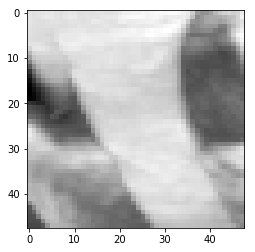

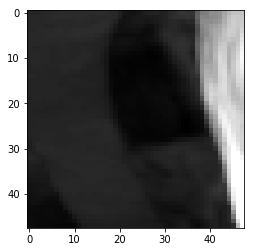

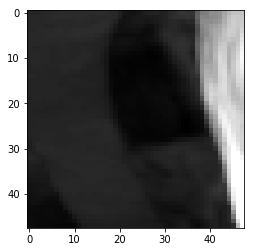

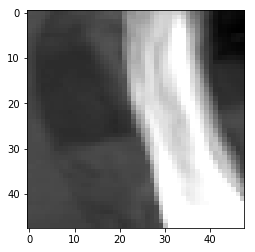

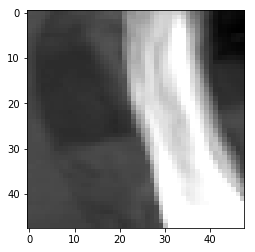

In [13]:
for i in range(len(X)):
    mp = np.amax(X[i],axis=(1))
    plt.figure()
    plt.imshow(mp, cmap='gray')
    plt.show()
    
plt.close('all')

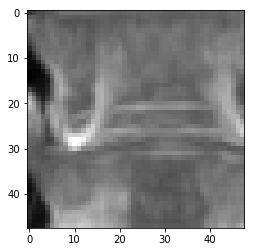

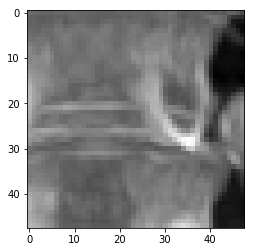

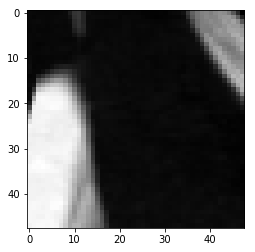

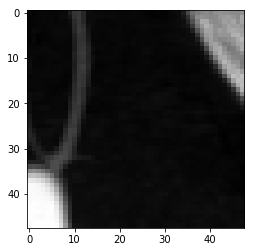

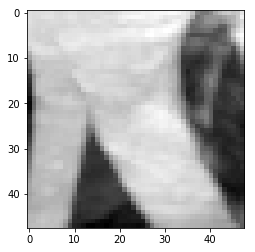

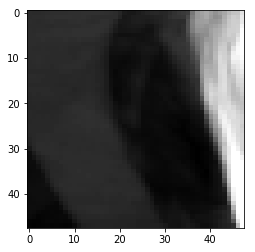

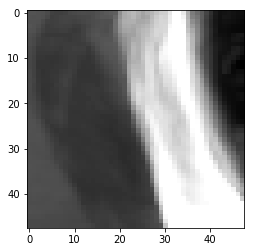

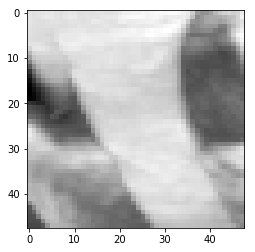

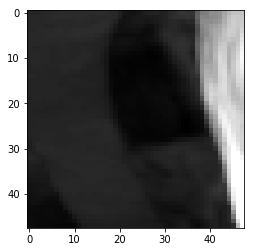

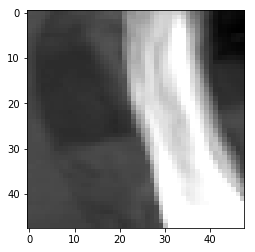

In [14]:
for i in range(len(X)):
    mp = np.amax(Y[i],axis=(1))
    plt.figure()
    plt.imshow(mp, cmap='gray')
    plt.show()
    
plt.close('all')